TensorFlow Version: 2.18.0

Please upload your kaggle.json file to authenticate.


Saving kaggle.json to kaggle.json

Kaggle API key uploaded successfully.
Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 78% 240M/306M [00:00<00:00, 677MB/s] 
100% 306M/306M [00:06<00:00, 48.9MB/s]
Dataset is ready at: /tmp/rps-cv-images
Created base directory for data splits at: /tmp/rps-data

Splitting data...
Data splitting complete.

Displaying sample images from the training set:


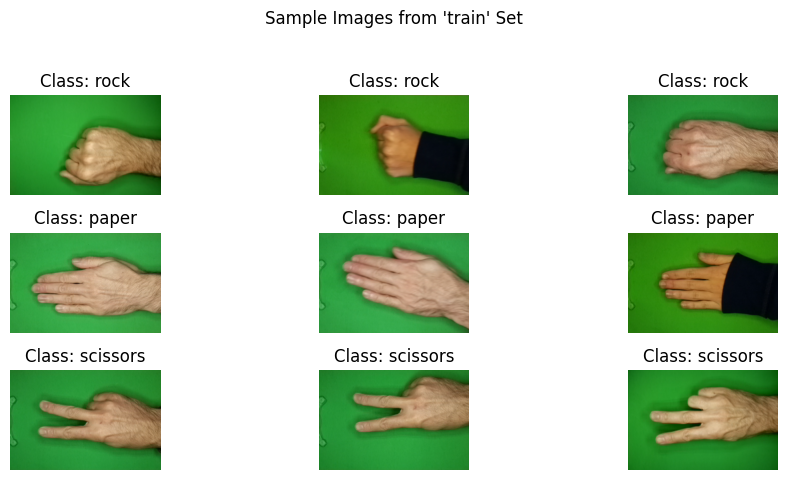

Found 1312 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Found 439 images belonging to 3 classes.

Data preprocessing pipelines are ready.


In [2]:
# --- 1. Consolidated Imports ---
# All libraries for the entire notebook are imported here for clarity and good practice.

# Standard libraries
import os
import shutil
import random

# Core data science and ML libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Keras specific imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image # For the custom image test

# Scikit-learn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Google Colab specific
from google.colab import files


# --- 2. Project Setup and Kaggle Dataset Download ---
print(f"TensorFlow Version: {tf.__version__}")

# Install Kaggle library
!pip install -q kaggle

print("\nPlease upload your kaggle.json file to authenticate.")
# Prompt user to upload their Kaggle API key
uploaded = files.upload()

if "kaggle.json" not in uploaded:
    print("\n'kaggle.json' not found. Please upload the file to proceed.")
else:
    print("\nKaggle API key uploaded successfully.")
    # Configure Kaggle CLI
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download and unzip the Rock-Paper-Scissors dataset
    print("Downloading and unzipping the dataset...")
    !kaggle datasets download -d drgfreeman/rockpaperscissors -p /tmp --force
    !unzip -q -o /tmp/rockpaperscissors.zip -d /tmp/

    original_dataset_dir = '/tmp/rps-cv-images'
    print(f"Dataset is ready at: {original_dataset_dir}")

    base_dir = "/tmp/rps-data"
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.makedirs(base_dir, exist_ok=True)
    print(f"Created base directory for data splits at: {base_dir}")

    # --- 3. Data Loading and Splitting ---
    labels = ['rock', 'paper', 'scissors']
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    for dir_path in [train_dir, validation_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)
        for label in labels:
            os.makedirs(os.path.join(dir_path, label), exist_ok=True)

    def split_data(source_dir, train_dir, validation_dir, test_dir, train_size=0.6, validation_size=0.2):
        print("\nSplitting data...")
        all_files = []
        for label in labels:
            folder_path = os.path.join(source_dir, label)
            files = [os.path.join(label, f) for f in os.listdir(folder_path) if os.path.getsize(os.path.join(folder_path, f)) > 0]
            all_files.extend(files)
        random.shuffle(all_files)
        total_files = len(all_files)
        train_end = int(total_files * train_size)
        validation_end = train_end + int(total_files * validation_size)
        train_files = all_files[:train_end]
        validation_files = all_files[train_end:validation_end]
        test_files = all_files[validation_end:]
        def copy_files(files, destination_dir):
            for file_path in files:
                label, file_name = os.path.split(file_path)
                shutil.copy(os.path.join(source_dir, file_path), os.path.join(destination_dir, label, file_name))
        copy_files(train_files, train_dir)
        copy_files(validation_files, validation_dir)
        copy_files(test_files, test_dir)
        print("Data splitting complete.")

    split_data(original_dataset_dir, train_dir, validation_dir, test_dir)

    # --- 4. Data Exploration and Visualization ---
    def plot_sample_images(directory, num_samples=3):
        plt.figure(figsize=(10, 5))
        for i, label in enumerate(labels):
            class_dir = os.path.join(directory, label)
            sample_images = random.sample(os.listdir(class_dir), num_samples)
            for j, img_name in enumerate(sample_images):
                ax = plt.subplot(len(labels), num_samples, i * num_samples + j + 1)
                img_path = os.path.join(class_dir, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path)
                plt.imshow(img)
                plt.title(f"Class: {label}")
                plt.axis("off")
        plt.suptitle(f"Sample Images from '{os.path.basename(directory)}' Set")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print("\nDisplaying sample images from the training set:")
    plot_sample_images(train_dir)

    # --- 5. Data Preprocessing Pipeline ---
    IMG_HEIGHT = 150
    IMG_WIDTH = 150
    BATCH_SIZE = 32
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')
    validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    print("\nData preprocessing pipelines are ready.")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Model 1: Baseline CNN Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,608,131 (21.39 MB)

 Trainable params: 5,608,131 (21.39 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
41/41 - 17s - 421ms/step - accuracy: 0.4657 - loss: 2.4614 - val_accuracy: 0.7957 - val_loss: 0.6841
Epoch 2/15
41/41 - 5s - 127ms/step - accuracy: 0.8018 - loss: 0.5701 - val_accuracy: 0.8462 - val_loss: 0.5377
Epoch 3/15
41/41 - 10s - 242ms/step - accuracy: 0.8598 - loss: 0.4314 - val_accuracy: 0.8726 - val_loss: 0.4026
Epoch 4/15
41/41 - 4s - 108ms/step - accuracy: 0.8758 - loss: 0.3884 - val_accuracy: 0.8245 - val_loss: 0.4733
Epoch 5/15
41/41 - 6s - 144ms/step - accuracy: 0.8918 - loss: 0.3255 - val_accuracy: 0.8966 - val_loss: 0.3488
Epoch 6/15
41/41 - 4s - 108ms/step - accuracy: 0.9284 - loss: 0.2513 - val_accuracy: 0.9087 - val_loss: 0.2911
Epoch 7/15
41/41 - 5s - 123ms/step - accuracy: 0.9527 - loss: 0.1972 - val_accuracy: 0.9207 - val_loss: 0.3362
Epoch 8/15
41/41 - 5s - 134ms/step - accuracy: 0.9520 - loss: 0.1715 - val_accuracy: 0.9327 - val_loss: 0.2864
Epoch 9/15
41/41 - 4s - 107ms/step - accuracy: 0.9611 - loss: 0.1624 - val_accuracy: 0.9279 - val_loss: 0.2665

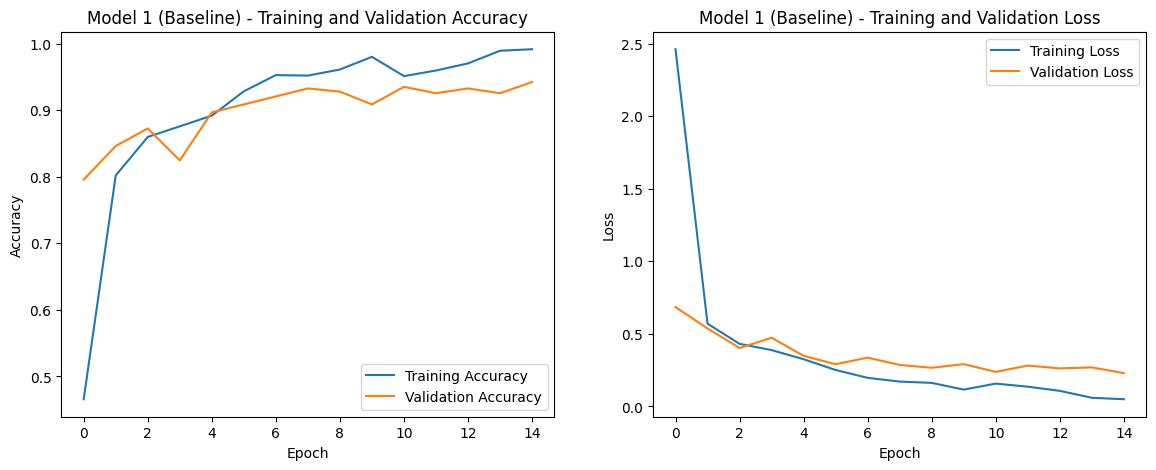

In [3]:
# --- Define the Baseline CNN Architecture ---
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# --- Compile the Model ---
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("--- Model 1: Baseline CNN Summary ---")
model_1.summary()

# --- Train the Model ---
print("\n--- Training Model 1 ---")
epochs = 15
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=2
)

# --- Visualize Training Results ---
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

print("\n--- Visualizing Model 1 Results ---")
plot_training_history(history_1, "Model 1 (Baseline)")


--- Model 2: Intermediate CNN Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,739 (40.58 MB)

 Trainable params: 10,636,739 (40.58 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model 2 ---
Epoch 1/15
41/41 - 19s - 455ms/step - accuracy: 0.6098 - loss: 1.0231 - val_accuracy: 0.7740 - val_loss: 0.6113
Epoch 2/15
41/41 - 5s - 124ms/step - accuracy: 0.8491 - loss: 0.4247 - val_accuracy: 0.8774 - val_loss: 0.3747
Epoch 3/15
41/41 - 5s - 121ms/step - accuracy: 0.9085 - loss: 0.2435 - val_accuracy: 0.9207 - val_loss: 0.2400
Epoch 4/15
41/41 - 4s - 106ms/step - accuracy: 0.9512 - loss: 0.1414 - val_accuracy: 0.9495 - val_loss: 0.1664
Epoch 5/15
41/41 - 10s - 250ms/step - accuracy: 0.9657 - loss: 0.0993 - val_accuracy: 0.9447 - val_loss: 0.2050
Epoch 6/15
41/41 - 5s - 127ms/step - accuracy: 0.9809 - loss: 0.0503 - val_accuracy: 0.9567 - val_loss: 0.1752
Epoch 7/15
41/41 - 5s - 123ms/step - accuracy: 0.9924 - loss: 0.0301 - val_accuracy: 0.9543 - val_loss: 0.2232
Epoch 8/15
41/41 - 5s - 110ms/step - accuracy: 0.9809 - loss: 0.0537 - val_accuracy: 0.9567 - val_loss: 0.1801
Epoch 9/15
41/41 - 10s - 249ms/step - accuracy: 0.9825 - loss: 0.0457 - val_accuracy

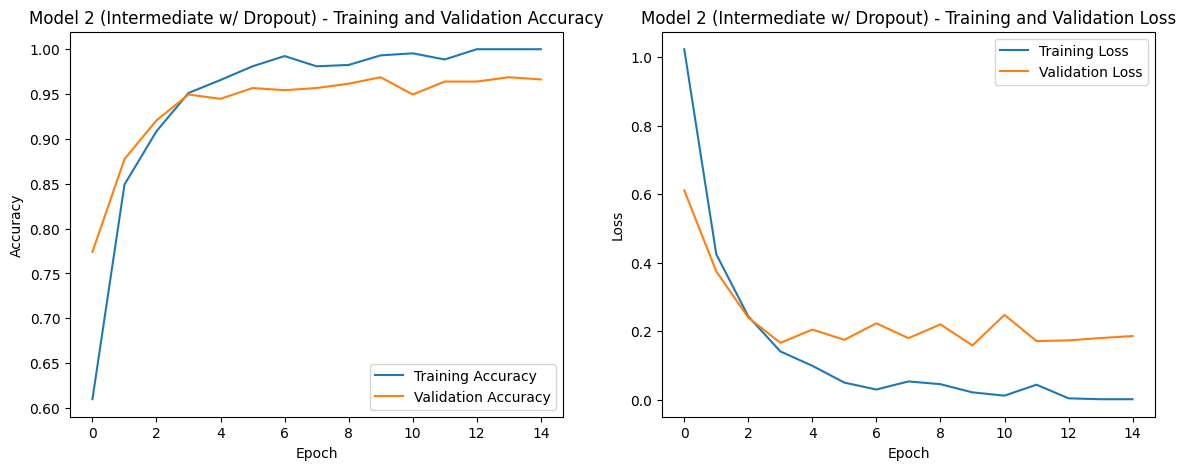

In [4]:
# --- Define the Intermediate CNN Architecture (Model 2) ---
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# --- Compile the Model ---
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("--- Model 2: Intermediate CNN Summary ---")
model_2.summary()

# --- Train the Model ---
print("\n--- Training Model 2 ---")
epochs = 15
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=2
)

# --- Visualize Training Results ---
print("\n--- Visualizing Model 2 Results ---")
plot_training_history(history_2, "Model 2 (Intermediate w/ Dropout)")


--- Creating Data Generator with Augmentation for Training ---
Found 1312 images belonging to 3 classes.

--- Model 3: CNN with Data Augmentation Summary ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,739 (40.58 MB)

 Trainable params: 10,636,739 (40.58 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model 3 ---
Epoch 1/25
41/41 - 19s - 472ms/step - accuracy: 0.3910 - loss: 1.1827 - val_accuracy: 0.6010 - val_loss: 0.9275
Epoch 2/25
41/41 - 12s - 284ms/step - accuracy: 0.5518 - loss: 0.9274 - val_accuracy: 0.3438 - val_loss: 0.9825
Epoch 3/25
41/41 - 21s - 501ms/step - accuracy: 0.6448 - loss: 0.7725 - val_accuracy: 0.8822 - val_loss: 0.4603
Epoch 4/25
41/41 - 12s - 288ms/step - accuracy: 0.7561 - loss: 0.6072 - val_accuracy: 0.8918 - val_loss: 0.3390
Epoch 5/25
41/41 - 20s - 499ms/step - accuracy: 0.7744 - loss: 0.5368 - val_accuracy: 0.8486 - val_loss: 0.3815
Epoch 6/25
41/41 - 12s - 284ms/step - accuracy: 0.7950 - loss: 0.4833 - val_accuracy: 0.9423 - val_loss: 0.2496
Epoch 7/25
41/41 - 12s - 281ms/step - accuracy: 0.8331 - loss: 0.4388 - val_accuracy: 0.9327 - val_loss: 0.2496
Epoch 8/25
41/41 - 12s - 284ms/step - accuracy: 0.8247 - loss: 0.4451 - val_accuracy: 0.9567 - val_loss: 0.1619
Epoch 9/25
41/41 - 19s - 475ms/step - accuracy: 0.8651 - loss: 0.3397 - val_ac

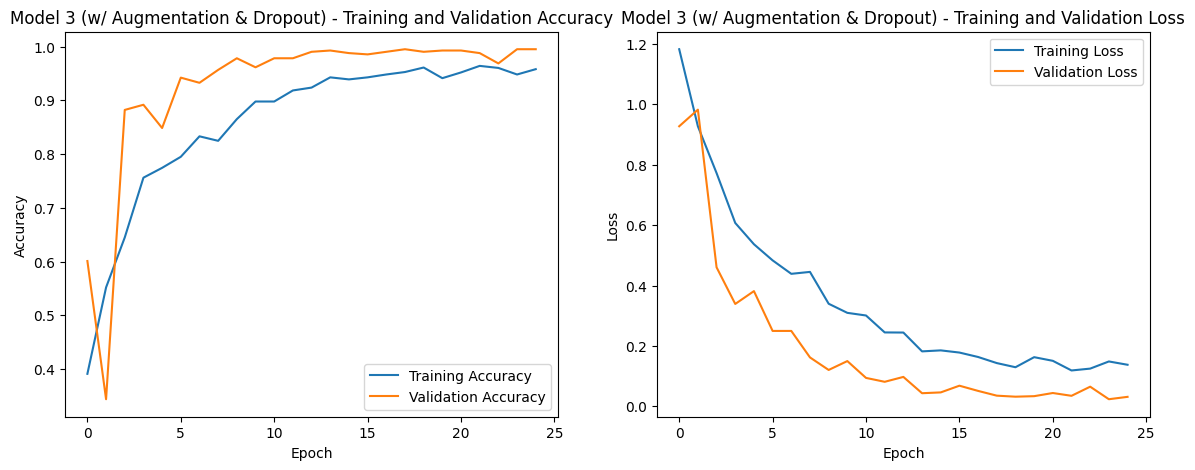

In [5]:
# --- Create a New Data Generator with Augmentation ---
print("--- Creating Data Generator with Augmentation for Training ---")
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- Define the Third CNN Architecture ---
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# --- Compile and Train the Model ---
model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Model 3: CNN with Data Augmentation Summary ---")
model_3.summary()

print("\n--- Training Model 3 ---")
epochs = 25
history_3 = model_3.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=2
)

# --- Visualize Training Results ---
print("\n--- Visualizing Model 3 Results ---")
plot_training_history(history_3, "Model 3 (w/ Augmentation & Dropout)")


--- Starting Hyperparameter Tuning for Learning Rate ---

--- Training with Learning Rate: 0.001 ---
Max Validation Accuracy for lr=0.001: 0.9931

--- Training with Learning Rate: 0.0001 ---
Max Validation Accuracy for lr=0.0001: 0.9657

--- Hyperparameter Tuning Complete ---
Best Learning Rate: 0.001
Best Validation Accuracy: 0.9931

--- Visualizing Best Model's Training History ---


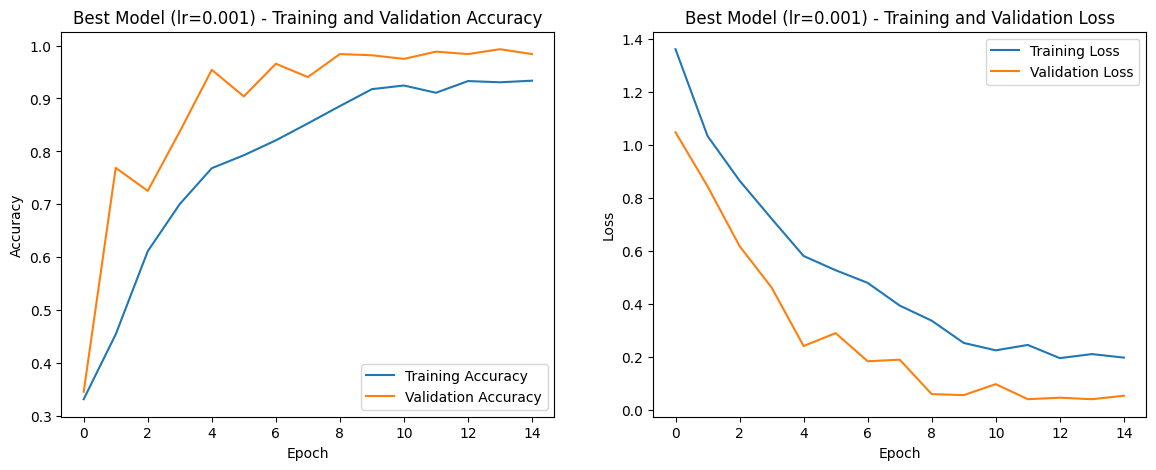


--- Final Evaluation on the Test Set ---
14/14 - 2s - 171ms/step - accuracy: 0.9772 - loss: 0.0767

Test Accuracy: 0.9772
Test Loss: 0.0767
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        rock       0.95      0.99      0.97       143
       paper       0.99      0.96      0.97       136
    scissors       0.99      0.99      0.99       160

    accuracy                           0.98       439
   macro avg       0.98      0.98      0.98       439
weighted avg       0.98      0.98      0.98       439


--- Confusion Matrix ---


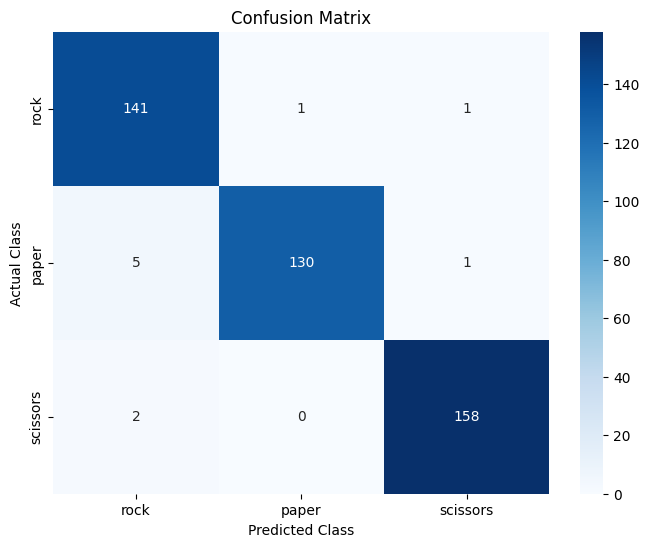

In [6]:
# --- 1. Hyperparameter Tuning ---
def create_model():
    """A helper function to create our best model architecture."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

learning_rates = [1e-3, 1e-4]
best_val_acc = 0
best_lr = None
best_history = None

print("--- Starting Hyperparameter Tuning for Learning Rate ---")

for lr in learning_rates:
    print(f"\n--- Training with Learning Rate: {lr} ---")
    model_tuned = create_model()
    model_tuned.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_tuned = model_tuned.fit(
        train_generator_augmented,
        epochs=15, # Reduced epochs for faster tuning
        validation_data=validation_generator,
        verbose=0
    )
    current_val_acc = max(history_tuned.history['val_accuracy'])
    print(f"Max Validation Accuracy for lr={lr}: {current_val_acc:.4f}")
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_lr = lr
        best_history = history_tuned
        model_tuned.save('best_model.keras')

print(f"\n--- Hyperparameter Tuning Complete ---")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

print("\n--- Visualizing Best Model's Training History ---")
plot_training_history(best_history, f"Best Model (lr={best_lr})")

# --- 2. Final Evaluation on the Test Set ---
print("\n--- Final Evaluation on the Test Set ---")
final_model = tf.keras.models.load_model('best_model.keras')
test_loss, test_acc = final_model.evaluate(test_generator, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# --- 3. Deeper Analysis: Classification Report and Confusion Matrix ---
Y_pred = final_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=labels))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


Final model loaded successfully.

Please upload your custom images for testing.


Saving my-paper-plain.jpg to my-paper-plain.jpg
Saving my-paper-shadow.jpg to my-paper-shadow.jpg
Saving my-rock-busy.jpg to my-rock-busy.jpg
Saving my-rock-plain.jpg to my-rock-plain.jpg
Saving my-scissors-angle.jpg to my-scissors-angle.jpg
Saving my-scissors-busy.jpg to my-scissors-busy.jpg

--- Running Generalization Test ---

Testing image: my-paper-plain.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


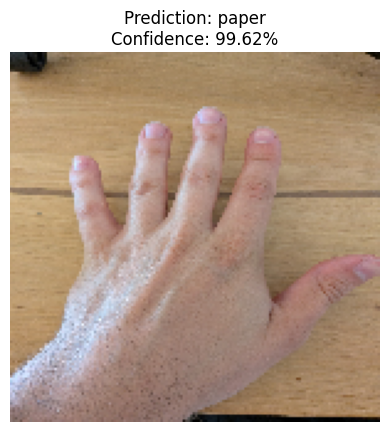


Testing image: my-paper-shadow.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


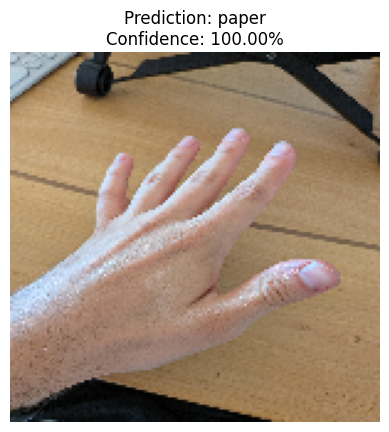


Testing image: my-rock-busy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


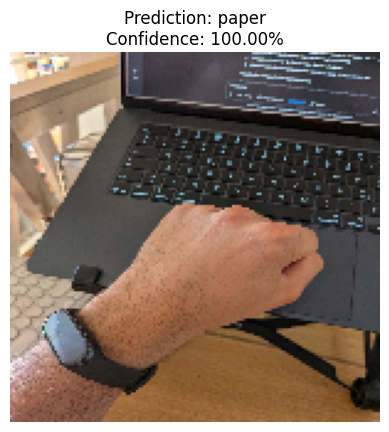


Testing image: my-rock-plain.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


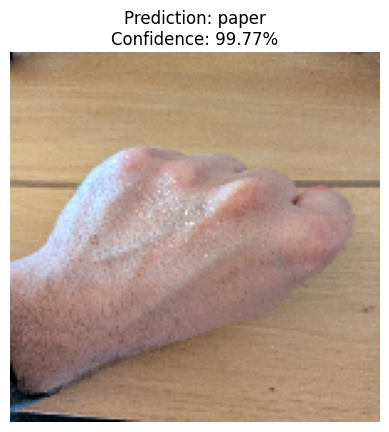


Testing image: my-scissors-angle.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


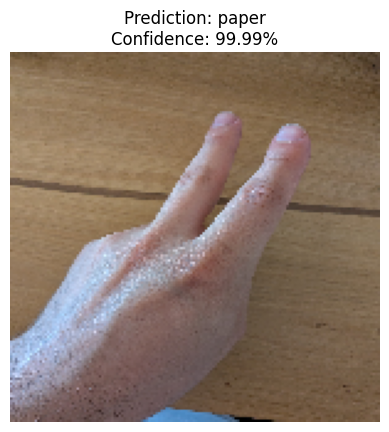


Testing image: my-scissors-busy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


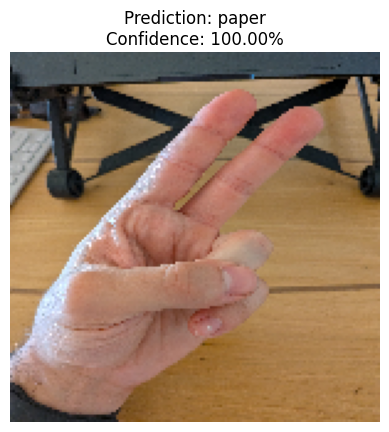

In [7]:
# --- 1. Load the Final Trained Model ---
try:
    final_model = tf.keras.models.load_model('best_model.keras')
    print("Final model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the previous cells have been run and 'best_model.keras' was saved.")

# --- 2. Function to Predict on a Single Image ---
def predict_custom_image(model, img_path):
    """
    Loads, preprocesses, and predicts a single custom image.
    """
    # --- THIS IS THE IMPROVEMENT ---
    # Dynamically get the class mapping from the training generator
    # instead of hardcoding it. This is more robust.
    class_indices = train_generator.class_indices
    # Invert the dictionary to map indices back to labels (e.g., {0: 'paper', 1: 'rock', ...})
    class_labels = {v: k for k, v in class_indices.items()}

    # Load the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to create a batch of 1
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image (normalize pixel values)
    img_preprocessed = img_array / 255.0

    # Make a prediction
    prediction = model.predict(img_preprocessed)
    predicted_class_index = np.argmax(prediction[0])

    # Use the dynamically generated labels
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction[0]) * 100

    # Display the results
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_label}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_class_label, confidence

# --- 3. Upload and Test Your Images ---
print("\nPlease upload your custom images for testing.")
uploaded_files = files.upload()

if not uploaded_files:
    print("\nNo files were uploaded.")
else:
    print("\n--- Running Generalization Test ---")
    for file_name, file_content in uploaded_files.items():
        # Save the uploaded file temporarily
        with open(file_name, 'wb') as f:
            f.write(file_content)

        print(f"\nTesting image: {file_name}")
        predict_custom_image(final_model, file_name)
